# **Reto 7: Clasificación de géneros musicales a partir de SVM**

Inicialmente, se procede a importar los datos, ejecutar la celda a continuación para descargar el archivo correspondiente y únicamente emplear los géneros *jazz and blues* y *soul and reggae* con el fin de tener un problema de clasificación balanceado.

In [1]:
!wget http://millionsongdataset.com/sites/default/files/AdditionalFiles/msd_genre_dataset.zip
!unzip msd_genre_dataset.zip
!cat msd_genre_dataset.txt | grep -E 'jazz and blues|soul and reggae' > filter_data.csv

--2019-10-29 17:32:16--  http://millionsongdataset.com/sites/default/files/AdditionalFiles/msd_genre_dataset.zip
Resolving millionsongdataset.com (millionsongdataset.com)... 173.231.209.32
Connecting to millionsongdataset.com (millionsongdataset.com)|173.231.209.32|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12656044 (12M) [application/zip]
Saving to: ‘msd_genre_dataset.zip’

msd_genre_dataset.z 100%[===================>]  12.07M  5.94MB/s    in 2.0s    

2019-10-29 17:32:19 (5.94 MB/s) - ‘msd_genre_dataset.zip’ saved [12656044/12656044]

Archive:  msd_genre_dataset.zip
  inflating: msd_genre_dataset.txt   


**Separación y normalización de parámetros:** ejecutar la celda a continuación para aleatorizar las posiciones de los datos, de forma que el entrenamiento no se realice con los mismos datos en todas las ocasiones. Igualmente, se tienen 8350 datos, de los cuales se emplearon 1000 como datos validación, 1000 como datos de prueba y el resto fueron utilizados durante el entrenamiento. Adicionalmente, se realizó un proceso de normalización a partir de un centrado y escalamiento de los datos, esto mediante la resta de la media y la división de este resultado entre la desviación estándar.

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import io
import numpy as np
from sklearn.metrics import accuracy_score

nombres = ['y','ID','Author','Name','x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11','x12','x13','x14','x15','x16','x17','x18','x19','x20','x21','x22','x23','x24','x25','x26','x27','x28','x29','x30']
datos = pd.read_csv('filter_data.csv', names = nombres)
datos = datos.reindex(np.random.permutation(datos.index))
data_array = datos.values

#Se ignora el artista, la ID y el nombre de la canción
relevant_data_0 = np.array([np.delete(x, [1,2,3]) for x in data_array])

#Selección de los géneros de interés y conversión a notación binaria (jazz and blues=0, soul and reggae=1)
relevant_data_1 = relevant_data_0
for x in relevant_data_0:
  if x[0] == 'jazz and blues':
    x[0] = -1
  elif x[0] == 'soul and reggae':
    x[0] = 1

relevant_data_1 = (relevant_data_1.astype(np.float))
dataX_raw = relevant_data_1[:,1:]
#Normalización de datos
dataX = ( dataX_raw - np.mean(dataX_raw) ) / np.std(dataX_raw)
dataY = relevant_data_1[:,0]

#Separación de datos de entrenamiento, validación y de prueba
trainX_raw = relevant_data_1[2000:,1:]
trainX = dataX[2000:]
trainY = dataY[2000:]

validationX = dataX[:1000]
validationY = dataY[:1000]

testX = dataX[1000:2000]
testY = dataY[1000:2000]

# Selección de modelo SVM
Según los requerimientos solicitados en este reto, se utilizará un kernel gaussiano, correspondiente a: $k(x_i, x_j)=exp(-\frac{|x_i-x_j|^2}{2\sigma^2})$.

**Variación de C (parámetro inversamente proporcional a la regularización):** en primer lugar, se realizó una variación del parámetro C, cuyo significado se relaciona de la siguiente forma: para mayores valores, se aceptará un menor margen de error, es decir, correspondiente a un mayor ajuste a los datos de entrenamiento, y por lo tanto, un aumento en la complejidad del modelo obtenido (puede producir *overfitting*); por el contrario, para valores pequeños de C, se aceptará mayor cantidad de errores de clasificación en el entrenamiento, reduciendo así la complejidad del modelo. Por lo tanto, con el fin de encontrar un valor apropiado que permita balancear la complejidad del modelo, se realizó un ciclo de prueba con distintos valores de C, validando su precisión y separando el mejor de los casos.

In [0]:
from sklearn.svm import SVC

train_ac = []
val_ac = []
max_val_ac = 0
max_val_ac_C = 0
C_min = -3
C_max = 3

exp = np.linspace(C_min, C_max, 50)

for i in range(len(exp)):
  sv_clf = SVC(C = 10**(exp[i]), kernel = 'rbf', gamma = 'auto')
  sv_clf.fit(trainX,trainY)

  pred_trainY = sv_clf.predict(trainX)
  pred_valY = sv_clf.predict(validationX)
  #print("Regularización log(C)=",exp[i])
  prec_val = accuracy_score(pred_valY,validationY)
  prec_train = accuracy_score(pred_trainY,trainY)
  #print("->Precisión en datos de entrenamiento:", prec_train)
  #print("->Precisión en datos de validación:", prec_val)
  train_ac.append(prec_train)
  val_ac.append(prec_val)
  if prec_val > max_val_ac:
    max_val_ac = prec_val
    sv_best_clf = sv_clf
    max_val_ac_C = exp[i]

-->Mejor clasificador con log_10(C)= 2.387755102040816 y precisión en datos de prueba: 0.842


Text(0.5, 1.0, 'Entrenamiento de modelo SVM con kernel gaussiano')

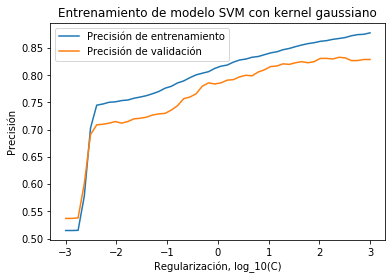

In [19]:
test_ac = accuracy_score(sv_best_clf.predict(testX),testY)
print("-->Mejor clasificador con log_10(C)=",max_val_ac_C,"y precisión en datos de prueba:", test_ac)

fig, ax = plt.subplots()
ax.plot(exp, train_ac, label='Precisión de entrenamiento')
ax.plot(exp, val_ac, label='Precisión de validación')
ax.legend()
plt.xlabel("Regularización, log_10(C)")
plt.ylabel("Precisión")
plt.title("Entrenamiento de modelo SVM con kernel gaussiano")

**Variación de $\gamma$ (gamma):** en segundo lugar, se realizó una variación del parámetro $\gamma$, el cual determina un factor de proporcionalidad en el resultado obtenido tras emplear los datos $x_i$ y $x_j$ como entradas.

In [0]:
train_ac = []
val_ac = []
max_val_ac = 0
max_val_ac_gamma = 0
gamma_min = 1e-3
gamma_max = 0.1

gamma_value = np.linspace(gamma_min, gamma_max, 50)

for i in range(len(gamma_value)):
  sv_clf = SVC(C = 10**max_val_ac_C, kernel = 'rbf', gamma = gamma_value[i])
  sv_clf.fit(trainX,trainY)

  pred_trainY = sv_clf.predict(trainX)
  pred_valY = sv_clf.predict(validationX)
  print("Kernel con gamma=",gamma_value[i])
  prec_val = accuracy_score(pred_valY,validationY)
  prec_train = accuracy_score(pred_trainY,trainY)
  #print("->Precisión en datos de entrenamiento:", prec_train)
  #print("->Precisión en datos de validación:", prec_val)
  train_ac.append(prec_train)
  val_ac.append(prec_val)
  if prec_val > max_val_ac:
    max_val_ac = prec_val
    best_clf = sv_clf
    max_val_ac_gamma = gamma_value[i]

-->Mejor clasificador con gamma= 0.02928571428571429 y precisión en datos de prueba: 0.842


Text(0.5, 1.0, 'Entrenamiento de modelo SVM con kernel gaussiano')

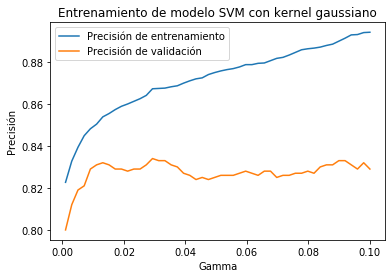

In [21]:
test_ac = accuracy_score(best_clf.predict(testX),testY)
print("-->Mejor clasificador con gamma=",max_val_ac_gamma,"y precisión en datos de prueba:", test_ac)

fig, ax = plt.subplots()
ax.plot(gamma_value, train_ac, label='Precisión de entrenamiento')
ax.plot(gamma_value, val_ac, label='Precisión de validación')
ax.legend()
plt.xlabel("Gamma")
plt.ylabel("Precisión")
plt.title("Entrenamiento de modelo SVM con kernel gaussiano")

**Empleando el valor $\gamma=\frac{1}{n*var(X)}$:** se realizó una comparación del desempeño del modelo respecto al recorrido realizado en el paso anterior, obteniendo los siguientes resultados.

In [17]:
sv_clf_scale = SVC(C = 10**max_val_ac_C, kernel = 'rbf', gamma = 'scale')
sv_clf_scale.fit(trainX,trainY)

pred_trainY = sv_clf_scale.predict(trainX)
pred_valY = sv_clf_scale.predict(validationX)
pred_testY = sv_clf_scale.predict(testX)
print("Kernel con gamma=1/n*X.var()")
prec_train = accuracy_score(pred_trainY,trainY)
prec_val = accuracy_score(pred_valY,validationY)
prec_test = accuracy_score(pred_testY,testY)
print("->Precisión en datos de entrenamiento:", prec_train)
print("->Precisión en datos de validación:", prec_val)
print("->Precisión en datos de prueba:", prec_test)

Kernel con gamma=1/n*X.var()
->Precisión en datos de entrenamiento: 0.8678740157480315
->Precisión en datos de validación: 0.833
->Precisión en datos de prueba: 0.844


**Conclusión final:** el mejor modelo emplea como parámetros: el valor de C obtenido al realizar un recorrido de forma logarítmica, e igualmente, empleando el valor de $\gamma=\frac{1}{n*var(X)}$, el cual se tiene definido por defecto en la función de la librería *sklearn*.

# Referencias

[1] RBF SVM parameters. Disponible en línea en: https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html

[2] Lozano, Fernando. Support Vector Machines. Universidad de los Andes (2019)